# COVID-19 data analysis

<img src=coronavirus-DNA-720.png  width="1200" >

In [1]:
#see online at https://covid19-jyy3.onrender.com/analysis

In [2]:
#Download world dataset
!curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv -o deaths_global.csv 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42749  100 42749    0     0  27211      0  0:00:01  0:00:01 --:--:-- 27194


In [3]:
#keep Italian repository update
!git pull https://github.com/pcm-dpc/COVID-19.git master --no-edit

From https://github.com/pcm-dpc/COVID-19
 * branch            master     -> FETCH_HEAD
Already up-to-date.


In [4]:
#libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import date2num
import gc
plt.style.use('ggplot')

In [5]:
#remove annoying worning about pandas assignment
pd.options.mode.chained_assignment = None

In [6]:
#format x axis with dates
def format_x_date(ax):
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin-1,xmax+1)
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    return xmin,xmax


def lollipop_plot(df, ax, date_col='data', value_col='not_admitted_ratio'):
    #make lollipop
    ax.plot(df[date_col].dt.date, df[value_col], "o",
        markersize=5, color='#007acc', alpha=0.9,label='Ratio')
    #make stick
    ax.vlines(x=df[date_col].dt.date, ymin=0, 
          ymax=df[value_col], color='#007acc', alpha=0.2, linewidth=5)

    #set ticks every week
    xmin,xmax=format_x_date(ax)
    ax.spines['bottom'].set_bounds(xmin+1, xmax-1)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ymin, ymax = ax.get_ylim()
    ax.spines['left'].set_bounds(0, ymax)
    
    return ax

# Load national dataset

In [8]:
df = pd.read_csv(os.path.join('dati-andamento-nazionale',
                               'dpc-covid19-ita-andamento-nazionale.csv'))
df.data = pd.to_datetime(df.data)
#assuming terapia_intensiva (intensive care) and deceduti (deaths)
#are cumulative. It is not specified in the dataset.
#Computing Daily new cases
df['ricoverati_con_sintomi_change']=df['ricoverati_con_sintomi']-df['ricoverati_con_sintomi'].shift(1)
df['terapia_intensiva_change']=df['terapia_intensiva']-df['terapia_intensiva'].shift(1)
df['deceduti_daily']=df['deceduti']-df['deceduti'].shift(1)


#The number of deaths over the number 
#of new cases admitted in intensive care (daily)
df['not_admitted_ratio'] = df['deceduti_daily']/(df['terapia_intensiva_change'])
#The number of deaths minus the number 
#of new cases admitted in intensive care (daily)
df['not_admitted'] = df['deceduti_daily']-(df['terapia_intensiva_change'])

#remove unused
df.drop(['stato'],axis=1,inplace=True)
df.drop(['data'],axis=1).tail()

#compute log of selected columns
cols = ['nuovi_attualmente_positivi',#new positive case now
          'deceduti_daily',#today deaths
          'terapia_intensiva',#Intensive care
          'deceduti'#deaths
         ]
for c in cols:
    
    df[c+'_log']=np.log10(df[c])
df[cols+['deceduti_daily_log']].head(5)

,nuovi_attualmente_positivi,deceduti_daily,terapia_intensiva,deceduti,deceduti_daily_log
0,221,NaN,26,7,NaN
1,90,3.0,35,10,0.477121
2,74,2.0,36,12,0.301030
3,203,5.0,56,17,0.698970
4,233,4.0,64,21,0.602060


## Fig1 
How the death rate changes before and after the introduction of social distancing mesures in Italy?

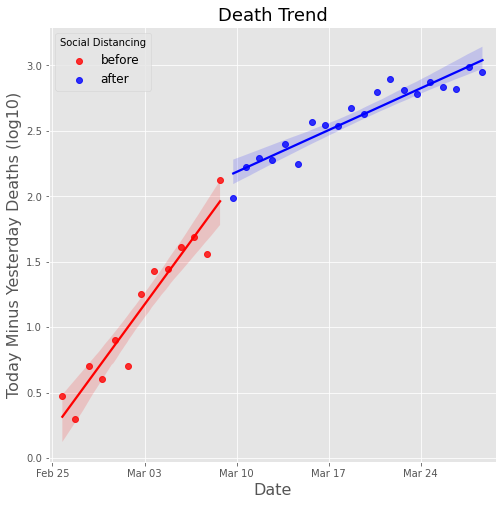

In [9]:
plt.style.use('ggplot')
before = df[df['data']<'2020-03-9']
before['ndata']=date2num(before['data'])
after = df[df['data']>'2020-03-9']
after['ndata']=date2num(after['data'])

x='ndata'
y='deceduti_daily_log'
fig,ax=plt.subplots(figsize=(8,8))
sns.regplot(x=x, y=y, color="r", data=before,ax=ax,label='before')
sns.regplot(x=x, y=y, color="b", data=after,ax=ax,label='after')
_,_=format_x_date(ax)
#plt.xticks(rotation=70,ha='right')
plt.xlabel('Date', fontsize='16')
plt.ylabel('Today Minus Yesterday Deaths (log10)',fontsize='16')
plt.title('Death Trend',fontsize='18')
plt.legend(title='Social Distancing',fontsize=12)
plt.savefig('Fig1.png')
plt.show()

## Fig2 
How many more people die respect to the people admitted in intensive care?

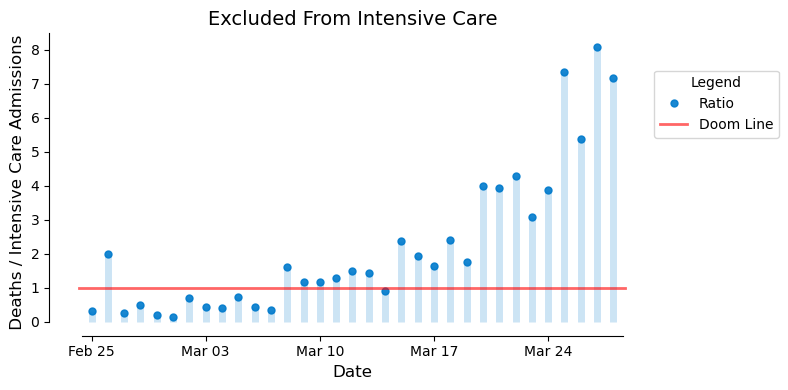

In [10]:
plt.style.use('default')

fig,ax=plt.subplots(figsize=(8,4))

ax = lollipop_plot(df, ax, date_col='data',
                   value_col='not_admitted_ratio')

ax.axhline(1, xmin=0.05,xmax=0.95,
           linewidth=2,color='r',alpha=0.6,label='Doom Line')

plt.xlabel('Date', fontsize='12')
plt.ylabel(' Deaths / Intensive Care Admissions', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.tight_layout()
plt.savefig('Fig2.png')
plt.show()

## Fig3
How many people die without getting intensive care

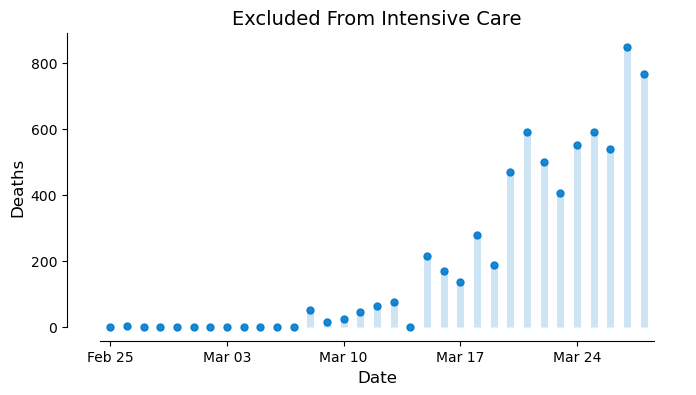

In [11]:
plt.style.use('default')
fig,ax=plt.subplots(figsize=(8,4))
df['not_admitted']=df['not_admitted'].clip(lower=0)
ax = lollipop_plot(df, ax, date_col='data',
                   value_col='not_admitted')

plt.xlabel('Date', fontsize='12')
plt.ylabel('Deaths', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')

#plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.savefig('Fig3.png')
plt.show()

## Extract UK data

In [12]:
temp = pd.read_csv('deaths_global.csv')
temp = temp[(temp['Country/Region']=='United Kingdom') & (temp['Lat']==55.3781)  ]
uk_df = temp.iloc[:,4:].T
uk_df.columns=['Death']
uk_df['Death_change']=uk_df['Death']-uk_df['Death'].shift(1)
uk_df=uk_df.reset_index()
uk_df['index'] = pd.to_datetime(uk_df['index'])
uk_df['Death_change_log']=np.log10(uk_df['Death_change'])
uk_df['Death_change_log']=uk_df['Death_change_log'].replace(-np.inf,np.nan)
uk_df=uk_df[~uk_df['Death_change_log'].isna()]
uk_df.columns=['date']+list(uk_df.columns[1:])
uk_df['ndate']=date2num(uk_df['date'])
uk_df.head()
del temp
gc.collect()

/Users/mtinti/miniconda3/envs/mixRP/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


5718

## Fig4 
How the Italian death ternd compare to the UK death trend?

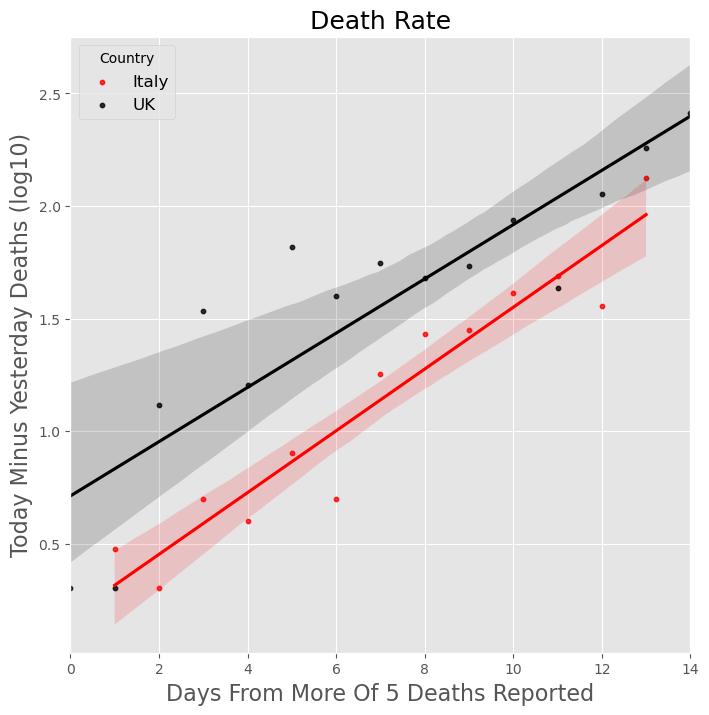

In [13]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(8,8))
y='deceduti_daily_log'
temp = df[df['data']<'2020-03-12']
temp = temp[~temp[y].isna()]
temp = temp[temp['deceduti']>=5]

sns.regplot(x=np.arange(0,before.shape[0]),
            y=y, color="r", data=before,ax=ax,label='Italy',scatter_kws={'s':10})

y='Death_change_log'
uk_df=uk_df[uk_df['Death']>=5]
sns.regplot(x=np.arange(0,uk_df.shape[0]),
            y=y, color="black", data=uk_df,ax=ax,label='UK',
            scatter_kws={'s':10,'marker':'x'})

plt.xlabel('Days From More Of 5 Deaths Reported', fontsize='16')
plt.ylabel('Today Minus Yesterday Deaths (log10)',fontsize='16')
plt.title('Death Rate',fontsize='18')
plt.legend(title='Country',fontsize=12,loc=2)
plt.savefig('Fig3.png')
plt.show()

In [ ]:
!jupyter nbconvert --to html_toc DataVis.ipynb

In [ ]:
!git add DataVis*
!git add -u
!git commit -m 'make function for lollipop plot'
!git push -u origin master